# ISM Difference to Ground Truth

Example images

### Imports

In [1]:
import sys
sys.path += [".."] # os.path.abspath("../img-phy-sim")

import img_phy_sim as ips
from img_phy_sim.data import PhysGenDataset, get_image

import numpy as np
import cv2
import matplotlib.pyplot as plt

d:\Programme\Anaconda\envs\img-phy-sim\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


### Data

In [2]:
n_samples = 4

In [3]:
# get image
input_samples = []
real = []

for i in range(n_samples):
    input_, output_ = get_image(mode='train', variation="sound_reflection", input_type="osm", output_type="complex_only", 
                                shuffle=True, return_output=True, as_numpy_array=True)
    input_samples.append(input_)
    real.append(output_)

PhysGen (sound_reflection) Dataset for train got created
PhysGen (sound_reflection) Dataset for train got created
PhysGen (sound_reflection) Dataset for train got created
PhysGen (sound_reflection) Dataset for train got created


In [4]:
output_.max()

np.float32(0.4705882)

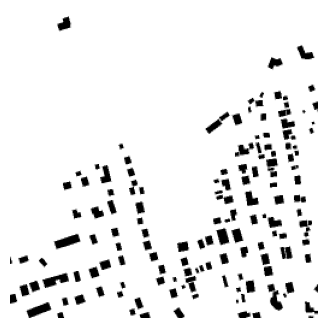

In [5]:
ips.img.imshow(input_samples[0], size=4)

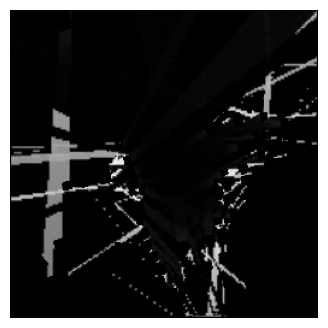

In [6]:
ips.img.imshow(real[0], size=4)

### Time

Before Numba optimization -> 3-5 minutes (180 - 300 seconds)

First Numba Optimization Wave: 20-30 seconds

Second Numba Optimization Wave: 200 - 300 milliseconds (0.2 - 0.3 seconds)

In [7]:
%%timeit

reflection_map = ips.ism.compute_reflection_map(
    source_rel=(0.5, 0.5),
    img=input_samples[0],
    wall_values=[0],   
    wall_thickness=1,
    max_order=1,
    step_px=1,
    ignore_zero_order=True
)

200 ms ± 8.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Calc ISM

In [8]:
pred_model = []
eval_score = []

for idx, cur_input in enumerate(input_samples):
    reflection_map = ips.ism.compute_reflection_map(
        source_rel=(0.5, 0.5),
        img=cur_input,
        wall_values=[0],   
        wall_thickness=1,
        max_order=1,
        step_px=1,
        approx_epsilon=0.5,
        ignore_ends=1,
    )
    pred_model.append(reflection_map)

    eval_score.append(
        ips.eval.calc_metrices(
            ips.ism.reflection_map_to_img(reflection_map), 
            real[idx], 
            rays_format_is_image=True, 
            should_print=True
        )
    )

Eval : F1=0.62, Recall=0.79, Precision=0.51
Eval : F1=0.43, Recall=0.93, Precision=0.28
Eval : F1=0.50, Recall=0.98, Precision=0.33
Eval : F1=0.79, Recall=0.82, Precision=0.77


In [9]:
pred_model_2 = []
eval_score_2 = []

for idx, cur_input in enumerate(input_samples):
    reflection_map = ips.ism.compute_reflection_map(
        source_rel=(0.5, 0.5),
        img=cur_input,
        wall_values=[0],   
        wall_thickness=1,
        max_order=1,
        step_px=1,
        approx_epsilon=0.5,
        ignore_zero_order=True,
        ignore_ends=1,
        
    )
    pred_model_2.append(reflection_map)

    eval_score_2.append(
        ips.eval.calc_metrices(
            ips.ism.reflection_map_to_img(reflection_map), 
            real[idx], 
            rays_format_is_image=True, 
            should_print=True
        )
    )

Eval : F1=0.56, Recall=0.58, Precision=0.53
Eval : F1=0.41, Recall=0.57, Precision=0.32
Eval : F1=0.40, Recall=0.50, Precision=0.34
Eval : F1=0.77, Recall=0.76, Precision=0.78


### Plot Helpers

In [10]:
def plot(ax, img, title="", sub_image=None, cmap="turbo", plot=True, normalize=True, vmin=0.0, vmax=1.0):
    img = img.astype(np.float32)
    # if np.max(img) > 2.0:
    #     img = 255 - img
    img[img > 0.0] = 1.0

    if type(sub_image) is not type(None):
        img_2 = sub_image.astype(np.float32)
        # if np.max(img_2) > 2.0:
        #     img_2 = 255 - img_2
        img_2[img_2 > 0.0] = 1.0

        assert img_2.shape == img.shape, "Shape mismatch"
        img = np.abs(img - img_2)

    if plot:
        ax.axis("off")
        color_ax = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        plt.colorbar(color_ax, ax=ax, fraction=0.046, pad=0.04)
    
    return img

### Plot Examples

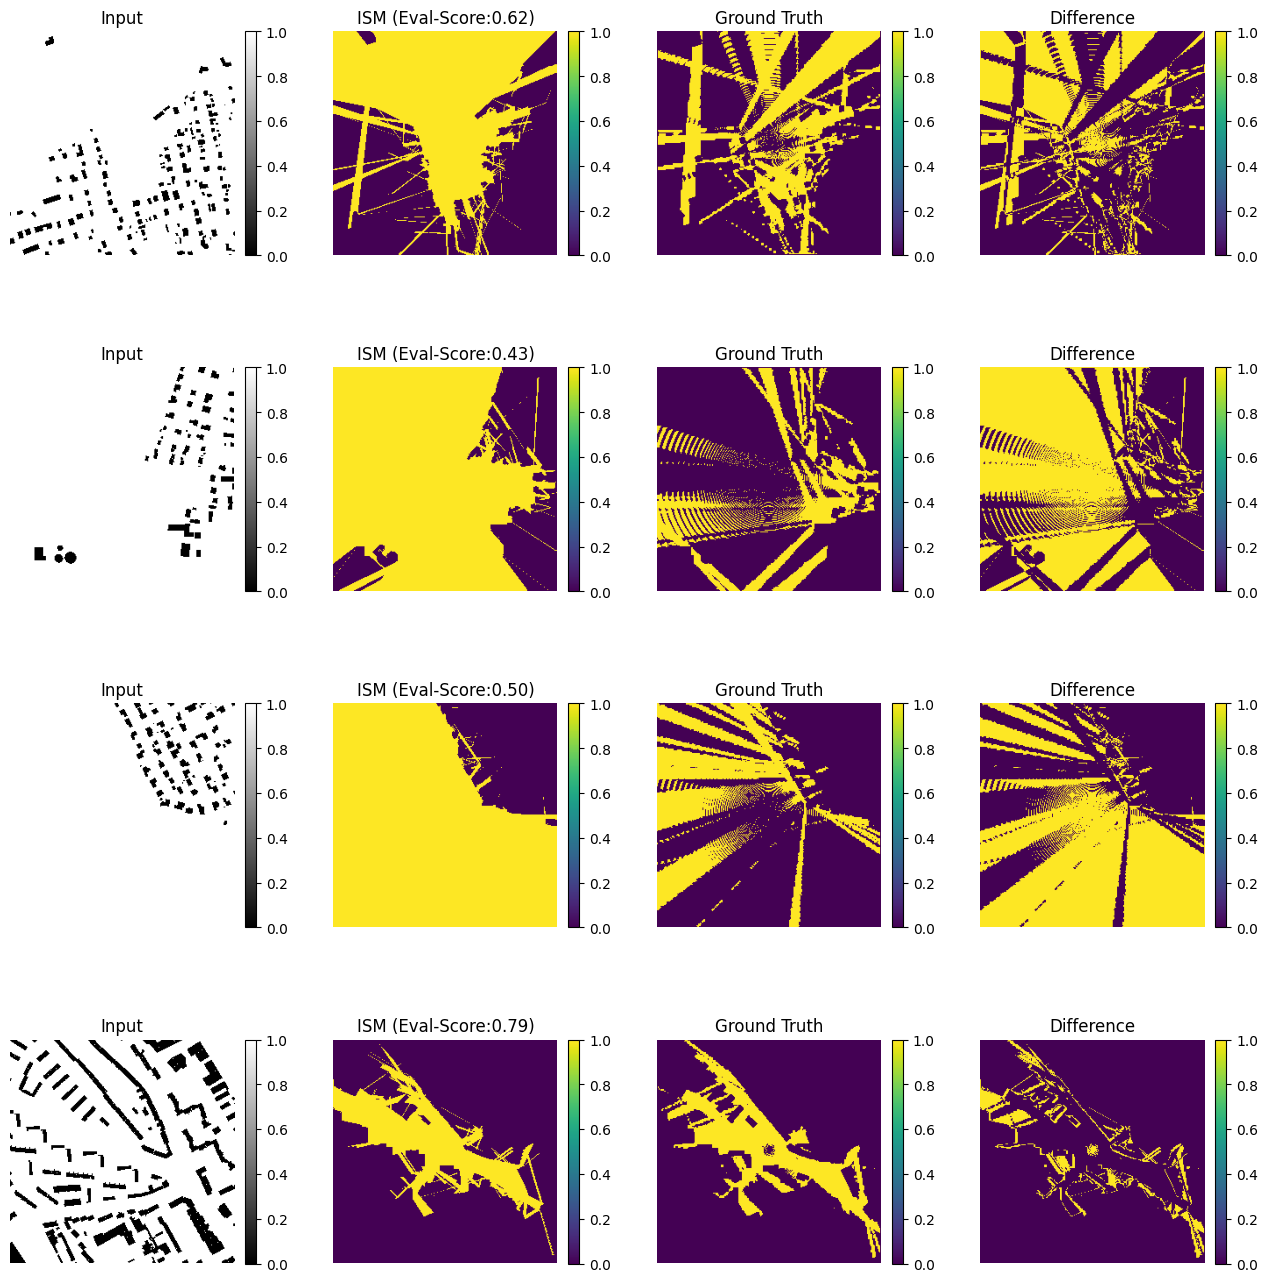

In [11]:
fig, ax = plt.subplots(nrows=n_samples, ncols=4, figsize=(4*4, n_samples*4))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_img in enumerate(input_samples):
    plot(ax[idx][0], img=cur_img, title=f"Input", cmap="gray")

for idx, cur_img in enumerate(pred_model):
    plot(ax[idx][1], img=cur_img, title=f"ISM (Eval-Score:{eval_score[idx][0]:.2f})", cmap="viridis")

for idx, cur_img in enumerate(real):
    plot(ax[idx][2], img=cur_img, title=f"Ground Truth", cmap="viridis")

for idx, cur_img in enumerate(pred_model):
    plot(ax[idx][3], img=cur_img, title=f"Difference", sub_image=real[idx], cmap="viridis")

plt.subplots_adjust(hspace=0.5)

plt.show();

ignore zero grad

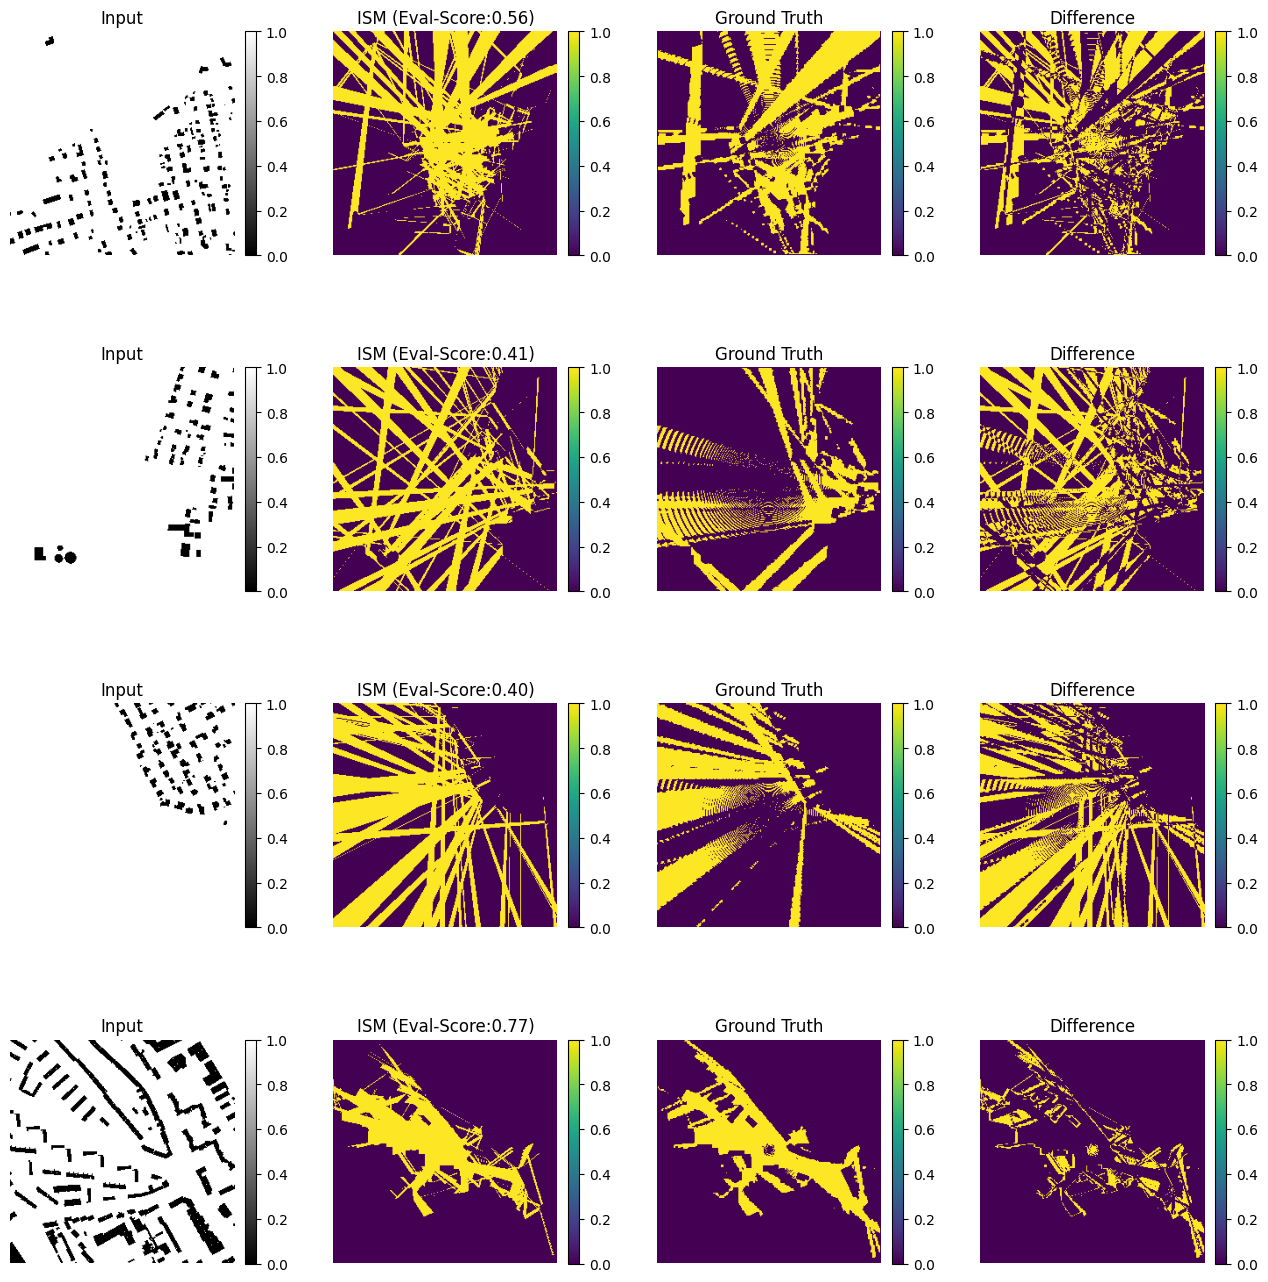

In [12]:
fig, ax = plt.subplots(nrows=n_samples, ncols=4, figsize=(4*4, n_samples*4))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_img in enumerate(input_samples):
    plot(ax[idx][0], img=cur_img, title=f"Input", cmap="gray")

for idx, cur_img in enumerate(pred_model_2):
    plot(ax[idx][1], img=cur_img, title=f"ISM (Eval-Score:{eval_score_2[idx][0]:.2f})", cmap="viridis")

for idx, cur_img in enumerate(real):
    plot(ax[idx][2], img=cur_img, title=f"Ground Truth", cmap="viridis")

for idx, cur_img in enumerate(pred_model_2):
    plot(ax[idx][3], img=cur_img, title=f"Difference", sub_image=real[idx], cmap="viridis")

plt.subplots_adjust(hspace=0.5)

plt.show();